In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr
import os
import numpy as np
from scipy.special import beta as BETA

In [2]:
device = "cpu"
if(torch.cuda.is_available()):
    deivce = "gpu"

torch.autograd.set_detect_anomaly(True)
plt.set_cmap("gray")

<Figure size 432x288 with 0 Axes>

In [3]:
class IBP:
    def __init__(self, alpha):
        self.alpha = alpha
    
    def rand(self, n, k_max):
        Z = []
        for i in range(n):
            nu = torch.distributions.beta.Beta(self.alpha,1).sample([k_max,1])
            p = self.break_stick_ibp(nu)
            z = torch.distributions.bernoulli.Bernoulli(p).sample().view(1,-1)
            Z.append(z)
        
        Z = torch.cat(Z, 0)
        return Z
    
    def rand_nu(self, nu, n= 1):
        p = self.break_stick_ibp(nu)
        Z = torch.distributions.bernoulli.Bernoulli(p).sample([n])
        return Z
    
    def break_stick_ibp(self, nu):
        K_max = nu.shape[0]
        p = []
        p.append(nu[0,:])
        for k in range(1,K_max):
            p.append(p[k-1]*nu[k,:])
        
        p = torch.cat(p,0)
        return p
        
    def break_log_stick_ibp(self, lognu):
        K_max = nu.shape[0]
        logp = []
        logp.append(lognu[0,:])
        for k in range(1,K_max):
            logp.append(logp[k-1] + lognu[k,:])
        
        logp = torch.cat(logp, 0)
        return logp

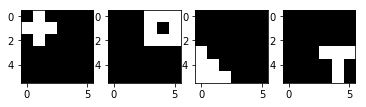

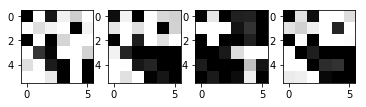

In [4]:
# Synthetic Data Genration

'''Basis Generation'''
k1 = np.zeros((6,6))
k1[0:3,1] = 1.0
k1[1,0:3] = 1.0

k2 = np.zeros((6,6))
k2[0:3,-3:] = 1.0
k2[1,-2] = 0

k3 = np.zeros((6,6))
k3[-3:,0:3] = 1.0
k3[-3:-1,2] = 0.0
k3[-3,1:2] = 0.0

k4 = np.zeros((6,6))
k4[-3:,-2] = 1.0
k4[-3,-3:] = 1.0

fig, ax = plt.subplots(1,4)

ax[0].imshow(k1)
ax[1].imshow(k2)
ax[2].imshow(k3)
ax[3].imshow(k4)


'''Data Generation'''

train_size = 3000
test_size = 500
prior = IBP(4.0)

# train_weights = prior.rand(train_size,4)
train_weights = np.random.rand(train_size, 4)>0.5
train_data = np.dot(train_weights,np.array([k1.reshape(-1,1),k2.reshape(-1,1),k3.reshape(-1,1),k4.reshape(-1,1)]).reshape(4,-1))
train_data += np.random.normal(0,0.1, size = [train_size,36])
train_data = np.clip(train_data, a_min = 0, a_max = 1)

test_weights = prior.rand(test_size,4)
test_data = np.dot(test_weights,np.array([k1.reshape(-1,1),k2.reshape(-1,1),k3.reshape(-1,1),k4.reshape(-1,1)]).reshape(4,-1))
test_data += np.random.normal(0,0.1, size = [test_size,36])
test_data = np.clip(test_data, a_min = 0, a_max = 1)

fig, ax = plt.subplots(1,4)

ax[0].imshow(train_data[0].reshape(6,6))
ax[1].imshow(train_data[300].reshape(6,6))
ax[2].imshow(test_data[0].reshape(6,6))
ax[3].imshow(test_data[300].reshape(6,6))

In [5]:
BATCH_SIZE = 100

trainloader = torch.utils.data.DataLoader(train_data.reshape(-1,1,6,6), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("Done !")

Done !


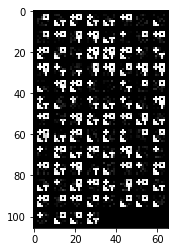

In [6]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images = dataiter.next()
show_images(images)

In [7]:
def get_rho_prob(rhos):
    
    rho_np = rhos.detach().numpy().reshape(-1)
    mt = rho_np.copy()
    
    for i in range(1,mt.shape[0]):
        prod = 1
        for j in range(i):
            prod*=rhos[j]
    
        mt[i-1] = prod*(1-rhos[i])

    return mt

In [8]:
class GLM_NP(nn.Module):
    def __init__(self, latent_variable_dim, prior , rholr = 10e-12, lr = 0.01):
        super(GLM_NP, self).__init__()
        
        alpha = prior.alpha
        self.prior = prior
        
        ### Global Params
        self.eps1 = torch.tensor(10e-6).float()
        self.eps2 = torch.tensor(10e-4).float()
        self.lr = lr
        self.D = 36
        self.sigX = 0.1
    
        # Encoder
        self.h_dim = 36
        self.mlp = nn.Linear(36,self.h_dim,'relu')
        
        # structured SBC
        self.aeys = nn.Parameter(torch.zeros(latent_variable_dim, 1) + self.inv_softplus(alpha) + torch.rand(latent_variable_dim,1)*0.01)
        self.bees = nn.Parameter(torch.zeros(latent_variable_dim, 1) + self.inv_softplus(torch.tensor(1.0)) + torch.rand(latent_variable_dim,1)*0.01)
        self.alpha = alpha
        self.beta = 1.0
        
        
        self.unif_sampler = torch.distributions.uniform.Uniform(self.eps1, 1-self.eps1)
        self.euler_constant = -torch.digamma(torch.tensor(1.0))
        
        # Z : GumbelBernoulli
        self.phi = nn.Parameter(torch.randn((self.h_dim + 1),latent_variable_dim)*0.001)
        self.temperature = 10
        self.t_prior = 0.1 # prior lambda

        
        # Basis
        self.A = nn.Parameter(torch.randn(latent_variable_dim, self.D)*0.001)
        
        ### Russian Roulette part
        self.rhos = torch.zeros(latent_variable_dim + 1,1) + 0.5
        self.rholr = rholr
        
        ## Optimizer
        self.optimizer = None
        self.K = latent_variable_dim
        self.max_K = latent_variable_dim
        
        
        self.print = False
        
                             
    def inv_softplus(self, alpha):
        return torch.log(torch.exp(alpha) - 1)
    
    def softplus(self, x):
        return torch.log(1 + torch.exp(x))
    
    def sample_nupi(self, N, K, sample_size = 1):
        
        a = self.softplus(self.aeys)[:K,:].view(K,1)
        b = self.softplus(self.bees)[:K,:].view(K,1)

#         py = []
#         nu = []
#         for i in range(N):
#             U = self.unif_sampler.sample([K,sample_size])
#             V = (1-(U+self.eps1).pow(1/a) + self.eps1 ).pow(1/b).view(1,-1, sample_size)
#             P = self.prior.rand_nu(V[0]).view(1,-1, sample_size)
#             py.append(P)
#             nu.append(V)
        
#         py = torch.cat(py, 0)
#         nu = torch.cat(nu, 0)
        
        
        U = self.unif_sampler.sample([K,sample_size])
        nu = (1-(U+self.eps1).pow(1/a) + self.eps1 ).pow(1/b).view(1,-1, sample_size)[0]
        py = self.prior.rand_nu(nu, N).view(N,-1, sample_size)
        
        return nu, py
        
    
    def GumbelBernoulliLogitLazyDense(self, x, k):
        
        N, D = x.shape
        
        x_cat = torch.cat((x.view(N,self.h_dim), torch.ones(N).view(N,-1)), 1).view(N,D+1)
        inter_z = torch.mm(x_cat, self.phi[:,:k])
        z, gi, pi, py = self.reparameterize_gumbel_kumaraswamy(inter_z, k) # N x K
        return z, gi, pi, py
    
    def encode(self, x, k):
        
        h = self.mlp(x)
        z, gi, pi, py = self.GumbelBernoulliLogitLazyDense(h, k)
        return z,gi,pi,py
        
    
    def reparameterize_gumbel_kumaraswamy(self, inter_z, p):
        '''Proper Sampling is required with masking'''
        
        N, K = inter_z.shape
        sample_size = 10
        
        G1 = self.unif_sampler.sample([N,K,sample_size])
        logit_G1 = G1.log() - (1-G1).log() 
        
        nu, pi = self.sample_nupi(N, K,sample_size) # K x sample_size
        
#         pi = self.prior.rand_nu(1, V)
        
        logit_pi = ((pi + self.eps1)/(1-pi + self.eps1)).log()
        logit_alpha = logit_pi + inter_z.view(N,K,1)
        alpha = logit_alpha.sigmoid()
        
        z1 = (logit_alpha + logit_G1)/self.temperature
        
        y = z1.sigmoid()
        
        return y, alpha, pi, nu
        
    def forward(self, input, k):
        x = input.view(-1, self.D)
        N, D = x.shape
        
        if(k == 0):
            k = self.get_current_K()
            
        z, gi, pi, py = self.encode(x,k)
        x = self.decode(z.mean(dim=-1).view(N,k), k)
        
        return x, z, gi, pi, py

    
    def decode(self, z, k):
        x = torch.mm(z, self.A[:k,:])
        return x
    
    
    def add_k_node(self, k):
        # Add k latent features ...
        if(k == 0):
            return 
        with torch.no_grad():
            self.aeys = nn.Parameter(torch.cat((self.aeys, torch.rand(k,1)*0.01 + self.softplus(self.alpha)), 0))
            self.bees = nn.Parameter(torch.cat((self.bees, torch.rand(k,1)*0.01 + self.softplus(torch.tensor(1.0))), 0))
            
            self.phi = nn.Parameter(torch.cat((self.phi, torch.randn((self.h_dim + 1),k)), 1))
            self.A = nn.Parameter(torch.cat((self.A, torch.randn(k, self.D)), 0))
            
            
            self.rhos = torch.cat((self.rhos, torch.zeros(k,1) + 0.5), 0)
    
    def del_k_node(self, k):
        # Retain k Latent Features ...
        if(k == 0 or k == self.get_current_K()):
            return
        with torch.no_grad():
            c_K = self.get_current_K()
            
            self.aeys = nn.Parameter(list(torch.split(self.aeys, c_K - k , 0))[0])
            self.bees = nn.Parameter(list(torch.split(self.bees, c_K - k , 0))[0])
            
            self.phi = nn.Parameter(list(torch.split(self.phi, c_K - k , 1))[0])
            self.A = nn.Parameter(list(torch.split(self.A, c_K - k , 0))[0])
            
            self.rhos = list(torch.split(self.rhos, c_K - k + 1, 0))[0]
                             
    def get_current_K(self):
        return self.K
    
    def constraint_proj(self):
        with torch.no_grad():
            self.aeys[self.aeys < 0.1] = 0.1
            self.bees[self.bees < 0.1] = 0.1
            self.rhos[self.rhos < 10e-6] = 10e-6
            self.rhos[self.rhos > 1 - 10e-6] = 1 - 10e-6
            self.A[self.A<0]=0.0
            pass
        
    def dynamize_Adam(self, reset = False, amsgrad = True):
        
        if(reset or self.optimizer == None):
            self.optimizer = torch.optim.Adam(self.parameters(), self.lr, amsgrad = amsgrad)
            self.optimizer.step()
        else:
            optim = self.optimizer
            newoptim = torch.optim.Adam(self.parameters(), self.lr)
            
            for i in range(len(optim.param_groups)):
                group_old = optim.param_groups[i]
                group_new = newoptim.param_groups[i]
                
                for j in range(len(group_old['params'])):
                    params_old = group_old['params'][j]
                    params_new = group_new['params'][j]
                    
                    amsgrad = group_old['amsgrad']
                    newoptim.param_groups[i]['amsgrad'] = amsgrad
                    
                    
                    state_old = optim.state[params_old]
                    state_new = newoptim.state[params_new]
                    
                    state_new['step'] = 1#state_old['step']
                    
                    state_new['exp_avg'] = torch.zeros_like(params_new.data)
                    state_new['exp_avg_sq'] = torch.zeros_like(params_new.data)
                    
                    
                    
                    exp_avg = state_new['exp_avg']
                    exp_avg_sq = state_new['exp_avg_sq']
                    max_exp_avg_sq = None
                    if(amsgrad):
                        state_new['max_exp_avg_sq'] = torch.zeros_like(params_new.data)
                        max_exp_avg_sq = state_new['max_exp_avg_sq']
                    
                    if(len(state_old['exp_avg'].shape)==2):
                        no,do = state_old['exp_avg'].shape
                        exp_avg[:no,:do] = state_old['exp_avg']
                        exp_avg_sq[:no,:do] = state_old['exp_avg_sq']
                        if(max_exp_avg_sq is not None):
                            max_exp_avg_sq[:no,:do] = state_old['max_exp_avg_sq']
                        
                    elif(len(state_old['exp_avg'].shape)==1):
                        no = state_old['exp_avg'].shape[0]
                        exp_avg[:no] = state_old['exp_avg']
                        exp_avg_sq[:no] = state_old['exp_avg_sq']
                        if(max_exp_avg_sq is not None):
                            max_exp_avg_sq[:no] = state_old['max_exp_avg_sq']
                        
                    else:
                        assert 1 == 2 ,'error in dynamic adam'
                        
                    state_new['exp_avg'] = exp_avg
                    state_new['exp_avg_sq'] = exp_avg_sq

                    newoptim.state[params_new] = state_new
                    
            self.optimizer = newoptim

In [9]:
def retain_k_nodes(model , new_K = 0):
    
    current_K = model.max_K
    if(current_K < new_K):
        model.add_k_node(new_K - current_K)
        model.max_K = new_K
    elif(current_K > new_K):
        model.del_k_node(current_K - new_K)
    else:
        pass
    
    model.K = new_K

In [10]:
def rrs_loss(model, images, one_minus_rho, fixed = False):
    
    curr_K = model.K
    l = torch.zeros(curr_K+1,1)
    one_minus_rho = one_minus_rho.view(-1,1)
    weight = torch.zeros_like(one_minus_rho)
    weight[curr_K] = one_minus_rho[curr_K]
    for i in range(1,curr_K+1):
        weight[curr_K-i] = weight[curr_K-i+1] + one_minus_rho[curr_K - i]
        
    weight = weight[1:]
    
    N = images.shape[0]
    global_multiplier = 1#(N/3000)*1000
    
    _, z, gi, pi, nu = model(images, 0)
    
    
    softplus = model.softplus
    eps = model.eps1
        
    a = model.softplus(model.aeys)[:curr_K,:].view(curr_K,1)
    b = model.softplus(model.bees)[:curr_K,:].view(curr_K,1)
        
    KL_kuma = ((a - model.alpha)/(a))*(-model.euler_constant -torch.digamma(b) - 1/b)
    KL_kuma += (a.log() + b.log()) + torch.log(torch.tensor(BETA(model.alpha,1)))
    KL_kuma -= (b - 1)/(b) 
    KL_kuma = (KL_kuma*global_multiplier).view(1,-1) # K 
    l[1:,:] += KL_kuma.view(curr_K,1)
    KL_kuma_w = (KL_kuma[:,:curr_K]*weight.view(1,-1)).sum()
    
    
    logit_pi = (pi+eps).log() - (1-pi+eps).log()
    logit_x  =  (z+eps).log() - (1 -z+eps).log()
    logit_gi = (gi+eps).log() - (1-gi+eps).log()

    tau = model.temperature
    tau_prior = model.t_prior
    exp_term_p = logit_pi - logit_x*(tau)
    exp_term_q = logit_gi - logit_x*(tau_prior)
    log_tau = torch.log(torch.tensor(model.temperature, requires_grad = False))
    log_pz = log_tau + exp_term_p - 2.0*softplus(exp_term_p)
    log_qz = log_tau + exp_term_q - 2.0*softplus(exp_term_q)
    
    qz = log_qz.exp()
    KL_gumb = (log_qz - log_pz)
    
    
    KL_gumb[KL_gumb != KL_gumb] = 0
#     KL_gumb[KL_gumb < 0] = 0
    KL_gumb = KL_gumb.mean(dim =-1).mean(dim = 0).view(1,-1)#.abs()
    l[1:,:] +=KL_gumb.view(curr_K,1)
    KL_gumb_w = (KL_gumb*weight.view(1,-1)).sum()
    
    
    
    lik_loss = 0
    for i in range(1,curr_K+1):
        sigma2X = 0.01
        recon_image = model.decode(z[:,:i,:].mean(dim=-1).view(N,i), i)
        Lik = -(0.5/sigma2X)*(recon_image - images.view(-1,36)).pow(2)
        Lik = torch.sum(Lik)/N - float(36*0.5*np.log(2*np.pi*sigma2X))
        lik_loss += Lik*one_minus_rho[i]
        l[i,:] -= Lik
        
    
    l_final = - lik_loss + KL_gumb_w + KL_kuma_w
    
    if(model.print):
        print(Lik , KL_gumb_w , KL_kuma_w)
    if(not fixed):
        return l, one_minus_rho, l_final
    else:
        return l, one_minus_rho,  KL_gumb[:-1,:].sum() + KL_kuma[:-1,:].sum() + l[-1,:].sum()

In [11]:
def train_step(model, images, sample_max = 5, sample = False, keep_graph = False):
    
    """ sample a trucation level and then do the same"""
    
    curr_K = model.get_current_K()
    model.rhos[0] = 0.9999
    
    with torch.no_grad():
        rhos = list(model.rhos)[:curr_K+1]
        L = len(rhos)
        samples = []
    
        for i in range(sample_max):

            k = 1

            while(True):
                u = np.random.uniform()
                if(u > rhos[k]):
                    samples.append(k)
                    break
                k += 1

                if(k > L-1 and sample):
                    rhos.append(0.5)
                    L = len(rhos)
                elif(k > L-1):
                    break
                
    
                
    samples.sort()
    if(sample):
        curr_K = model.get_current_K()
        new_value = int(np.max(samples[-5:]))
        
        if(new_value > model.max_K):
            model.optimizer = retain_k_nodes(model , new_K = new_value)
            model.K = new_value
            model.max_K = new_value
            model.dynamize_Adam()
        else:
            retain_k_nodes(model , new_K = model.max_K)
            model.K = new_value
            
    else:
        new_value = curr_K
        
    with torch.no_grad():
        curr_K = model.K
        while(len(rhos)<curr_K+1):
            rhos.append(0.5)
        omrho = 1 - np.array(rhos)[:curr_K+1]
        weight = omrho*0
        for i in range(len(samples)):
            val = samples[i]+1
            weight[:val] += omrho[:val]
        weight/=len(samples)
        weightf = torch.tensor(weight).view(1,-1).float()

        if(model.print):
            print("Current Truncated Level :", new_value)
            print(model.rhos)
        
    model.optimizer.zero_grad()
    curr_K = model.get_current_K()
    
    l ,one_minus_rho, l_final_params = rrs_loss(model, images, weightf[:,:curr_K+1], fixed = False)
    
    if(l_final_params != l_final_params):
        pass
    else:
        l_final_params.backward()
        model.optimizer.step()
        model.constraint_proj()
        
        rgg = torch.zeros_like(model.rhos)
        for ck in samples:
            ckp1 = ck + 1
            rho_grads = [torch.tensor([0.0])]
            rho_rr = list(model.rhos)[:ckp1]
            l_rr = l[1:ckp1]


            for k in range(1,ckp1):
                grad = torch.tensor([0.0])
                if(k > l_rr.shape[0]):
                    pass
                else:
                    for i in range(k-1, l_rr.shape[0]):
                        wi = 0
                        if(k-1 == i):
                            wi = 1/(rho_rr[k] - 1)
                        else:
                            wi = 1/rho_rr[k]
                            
                        grad += (1-rho_rr[i+1])*wi*l_rr[i]

                rho_grads.append(grad)
            rho_grads = torch.tensor(rho_grads).view(-1,1)
            rgg[:ckp1] += rho_grads

        rgg/=len(samples)
        rho_grads = rgg[:curr_K+1]
        

        rho_grads = rho_grads.clamp(-100,100)
        rho_grads[rho_grads != rho_grads] = 0.0
        rho_logit = ((model.rhos).log() - (1 - model.rhos).log())[:curr_K+1]
        sig_rho = rho_logit.sigmoid()


        rho_logit[:curr_K+1,:] = rho_logit[:curr_K+1,:] - model.rholr*(sig_rho*(1-sig_rho)*rho_grads.view(-1,1))
        with torch.no_grad():
            model.rhos[:curr_K+1,:] = rho_logit.sigmoid()



            
#         except:
#             print("failed")

    
    
    return l_final_params

In [18]:
prior = IBP(torch.tensor(2.0))
glm = GLM_NP(1,prior,5*10e-4,0.01)

In [19]:
## train
train_loss = []
glm.temperature = 10.0
keep_graph = True

In [20]:
glm.dynamize_Adam(True)

In [21]:
glm.lr = 0.01
glm.rholr = 10e-3

Epoch no : 20 batch_no : 20 curr_loss : -0.3845751190185547 temp : 0.1 lr : 0.01
Current Truncated Level : 6
tensor([[0.9999],
        [0.9982],
        [0.9980],
        [0.9961],
        [0.9308],
        [0.2835],
        [0.1182],
        [0.2715],
        [0.5453],
        [0.6116],
        [0.5458],
        [0.4998],
        [0.5274],
        [0.5105]])
tensor(41.7959, grad_fn=<SubBackward0>) tensor(6.0640, grad_fn=<SumBackward0>) tensor(2.3898e-13, grad_fn=<SumBackward0>)


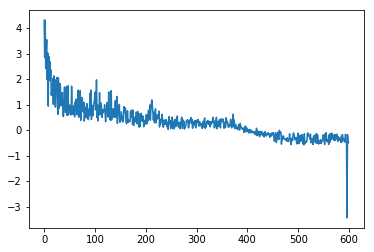

In [22]:
for epoch in range(20):
    
    for i, data in enumerate(trainloader, 0):
        images = data.float()
        images = images.to(device)
            
        if(i%1== 0 and True):
            l = train_step(glm, images, 10, True, keep_graph)
        else:
            l = train_step(glm, images, 10, False, keep_graph)
        
#         assert 1== 2
        
        
        train_loss.append((l/((1 - glm.rhos[:glm.K]).sum())).item() / len(images))

        glm.temperature /= 1.01
        if(glm.temperature < .1):
            glm.temperature = 0.1
#         glm.lr/=1.001
#         if(glm.lr < 0.001):
#             glm.lr = 0.001
        
        glm.print = False

        if(i%10 == 0):
            clr(wait = True)
            print("Epoch no :", epoch + 1, "batch_no :", i, "curr_loss :",  train_loss[-1], "temp :", glm.temperature, "lr :", glm.lr)
            glm.print = True
        
        glm.dynamize_Adam()  
#         glm.rhos[glm.K:]= 0.5
        
plt.plot(train_loss)
plt.show()

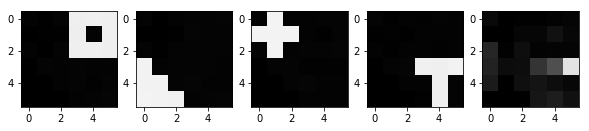

In [23]:
probs = get_rho_prob(glm.rhos)[:-1]
K = np.floor(np.random.choice(np.arange(glm.rhos.shape[0]-1), p = probs/probs.sum(), size = 1000).mean()).astype(np.int)+1
fig, ax = plt.subplots(1,K, figsize = [2*K,6])
for i in range(K):
    f = ax[i].imshow((glm.A[i].abs()).view(6,6).detach(), cmap= 'gray', vmin = 0 , vmax = 1)

plt.savefig('sample.png')
plt.show()

In [24]:
recon_image, z, gi, pi, _ = glm(images, 5)

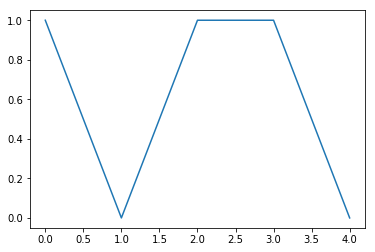

In [25]:
plt.plot(z[95,:,0].detach().numpy())

In [26]:
glm.A.min(), glm.A.max()

(tensor(0., grad_fn=<MinBackward1>), tensor(2.8348, grad_fn=<MaxBackward1>))

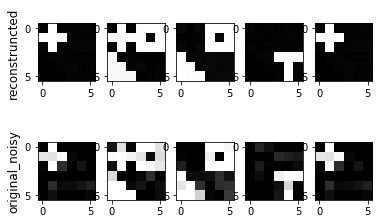

In [27]:
fig, ax = plt.subplots(2,5)
for k in range(5):
    
    idx = np.random.choice(np.arange(gi.shape[0]))

    z = ax[0][k].imshow(recon_image[idx,:].view(6,6).detach())
    z = ax[1][k].imshow(images[idx,:].view(6,6).detach())

ax[0][0].set_ylabel('reconstruncted', rotation=90, size='large')
ax[1][0].set_ylabel('original_noisy', rotation=90, size='large')
plt.savefig('Recons')
plt.show()

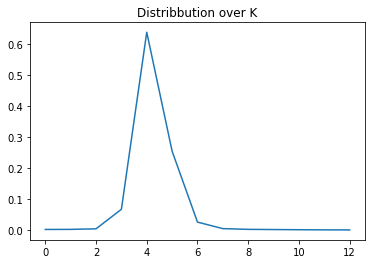

In [28]:
plt.plot(get_rho_prob(glm.rhos)[:-1])
plt.title("Distribbution over K")
plt.savefig("dist_K.png")

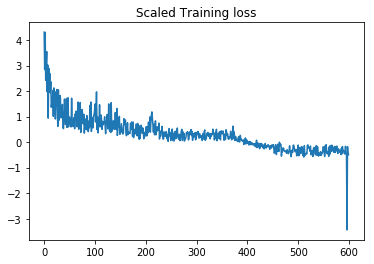

In [29]:
plt.plot(train_loss)
plt.title("Scaled Training loss")
plt.savefig('Training_loss')
plt.show()